# Feature Engineering

### 1. Load train, test dataset

In [1]:
import pandas as pd

train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')

### 2. Drop dummy features

In [2]:
# drop dummy features
train.drop(['id', 'vehicle_restricted', 'height_restricted'], axis=1, inplace=True)
test.drop(['id', 'vehicle_restricted', 'height_restricted'], axis=1, inplace=True)

### 3. Make datetime feature

In [3]:
# 'date'
train['date'] = train['base_date'].astype(str) + " " + train['base_hour'].astype(str) + ":00"
test['date'] = test['base_date'].astype(str) + " " + test['base_hour'].astype(str) + ":00"

train['date'] = pd.to_datetime(train['date'], format='%Y%m%d %H:%M')
test['date'] = pd.to_datetime(test['date'], format='%Y%m%d %H:%M')

In [4]:
train[['date']].head()

,date
0,2022-06-23 17:00:00
1,2022-07-28 21:00:00
2,2021-10-10 07:00:00
3,2022-03-11 13:00:00
4,2021-10-05 08:00:00


### 4. Add 'cars_per_timespace' feature

In [5]:
# counting current cars per same date, road

train['cars_per_timespace'] = 0
test['cars_per_timespace'] = 0

tr = train.groupby(['date', 'road_name'], as_index=True).count().reset_index()
te = test.groupby(['date', 'road_name'], as_index=True).count().reset_index()

tr = tr[['date', 'road_name', 'cars_per_timespace']]
te = te[['date', 'road_name', 'cars_per_timespace']]

train.drop(['cars_per_timespace'], axis=1, inplace=True)
test.drop(['cars_per_timespace'], axis=1, inplace=True)

merged_tr = pd.merge(tr, train, on=['date', 'road_name'])
merged_te = pd.merge(te, test, on=['date', 'road_name'])

train = merged_tr
test = merged_te

array([[<AxesSubplot: title={'center': 'cars_per_timespace'}>]],
      dtype=object)

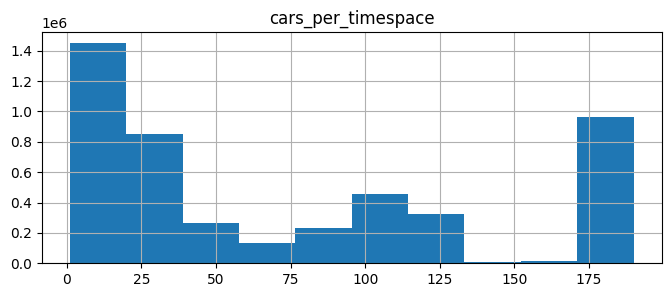

In [6]:
train[['cars_per_timespace']].hist(figsize=(8, 3))

In [7]:
corr_matrix = train.corr()
corr_matrix['target'].sort_values(ascending=False)['cars_per_timespace']

/tmp/ipykernel_18356/175559223.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


0.10517835292208966

### 5. Add 'month_visit' feature

In [8]:
# train 데이터 : 2021.9 ~ 2022.7
# test 데이터 : 2022.8
# 외부 데이터는 2022년 8월 이전의 데이터만 사용가능하므로 train, test 데이터 모두 적용 불가
# 결론적으로 'month_visit'은 사용할 수 없는 feature

In [9]:
import os

ext_data_path = '../external_data/visitor/'
month_data_list = os.listdir(ext_data_path)

train['month_visit'] = 0
test['month_visit'] = 0

for month_data in month_data_list:
    month_visit = pd.read_excel(ext_data_path + month_data).loc[2, ['Unnamed: 6']][0]
    index = train.index[(train['date'].dt.year == int(month_data[0:4])) & (train['date'].dt.month == int(month_data[5:7]))]
    train.loc[index, ['month_visit']] = month_visit


In [10]:
corr_matrix = train.corr()
corr_matrix['target'].sort_values(ascending=False)['month_visit']

/tmp/ipykernel_18356/4029310303.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


-0.04104133928929515

In [11]:
train.drop('month_visit', axis=1, inplace=True)
test.drop('month_visit', axis=1, inplace=True)

### 6. Add 'distance_start_end' feature

In [12]:
from haversine import haversine

distance_list = []
for i in range(train.shape[0]):
    start = (train['start_latitude'][i], train['start_longitude'][i])
    end = (train['end_latitude'][i], train['end_longitude'][i])
    distance_list.append(haversine(start, end, unit='m'))
    
train['distance_start_end'] = distance_list

distance_list = []
for i in range(test.shape[0]):
    start = (test['start_latitude'][i], test['start_longitude'][i])
    end = (test['end_latitude'][i], test['end_longitude'][i])
    distance_list.append(haversine(start, end, unit='m'))
    
test['distance_start_end'] = distance_list

In [13]:
corr_matrix = train.corr()
corr_matrix['target'].sort_values(ascending=False)['distance_start_end']

/tmp/ipykernel_18356/86490354.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


0.18093436703564603

### 7. Add 'day_visit' feature

In [14]:
# train 데이터 : 2021.9 ~ 2022.7
# test 데이터 : 2022.8
# 외부 데이터는 2022년 8월 이전의 데이터만 사용가능하므로 train, test 데이터 모두 적용 불가
# 'month_visit'과 동일하게 'day_visit'또한 사용할 수 없는 feature

In [15]:
day_visit = pd.read_csv('../external_data/day_visit.csv')
merged = pd.merge(day_visit, train, on=['base_date'])
train = merged

In [16]:
corr_matrix = train.corr()
corr_matrix['target'].sort_values(ascending=False)['day_visit']

/tmp/ipykernel_18356/3416894958.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


-0.026750993068675018

In [17]:
train.drop('day_visit', axis=1, inplace=True)

### 8. Add 'holiday' feature

In [18]:
import holidays

holidays = holidays.KR()
train['holiday'] = train.date.apply(lambda x: 1 if x in holidays else 0)
test['holiday'] = test.date.apply(lambda x: 1 if x in holidays else 0)

In [19]:
corr_matrix = train.corr()
corr_matrix['target'].sort_values(ascending=False)['holiday']

/tmp/ipykernel_18356/2725702628.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


0.010734851962996268

### 9. Add 'year', 'month', 'day', 'hour' features

In [20]:
train['year'], test['year'] = train['date'].dt.year, test['date'].dt.year
train['month'], test['month'] = train['date'].dt.month, test['date'].dt.month
train['day'], test['day'] = train['date'].dt.day, test['date'].dt.day
train['hour'], test['hour'] = train['date'].dt.hour, test['date'].dt.hour

In [21]:
corr_matrix = train.corr()
corr_matrix['target'].sort_values(ascending=False)[['year', 'month', 'day', 'hour']]

/tmp/ipykernel_18356/197084768.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


year    -0.031676
month   -0.000225
day     -0.011605
hour    -0.159407
Name: target, dtype: float64

---

---

# < Correlation, Importance Check >

- 새로 추가된 features
    - month
    - day
    - year
    - holiday
    - cars_per_timespace
    - distance_start_end

/tmp/ipykernel_18356/1748714786.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask_mat = np.eye(len(sample.corr()), dtype=bool)
/tmp/ipykernel_18356/1748714786.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(sample.corr(), mask=mask_mat, ax=ax, annot=True, fmt=".2f", cmap='coolwarm', center=0)


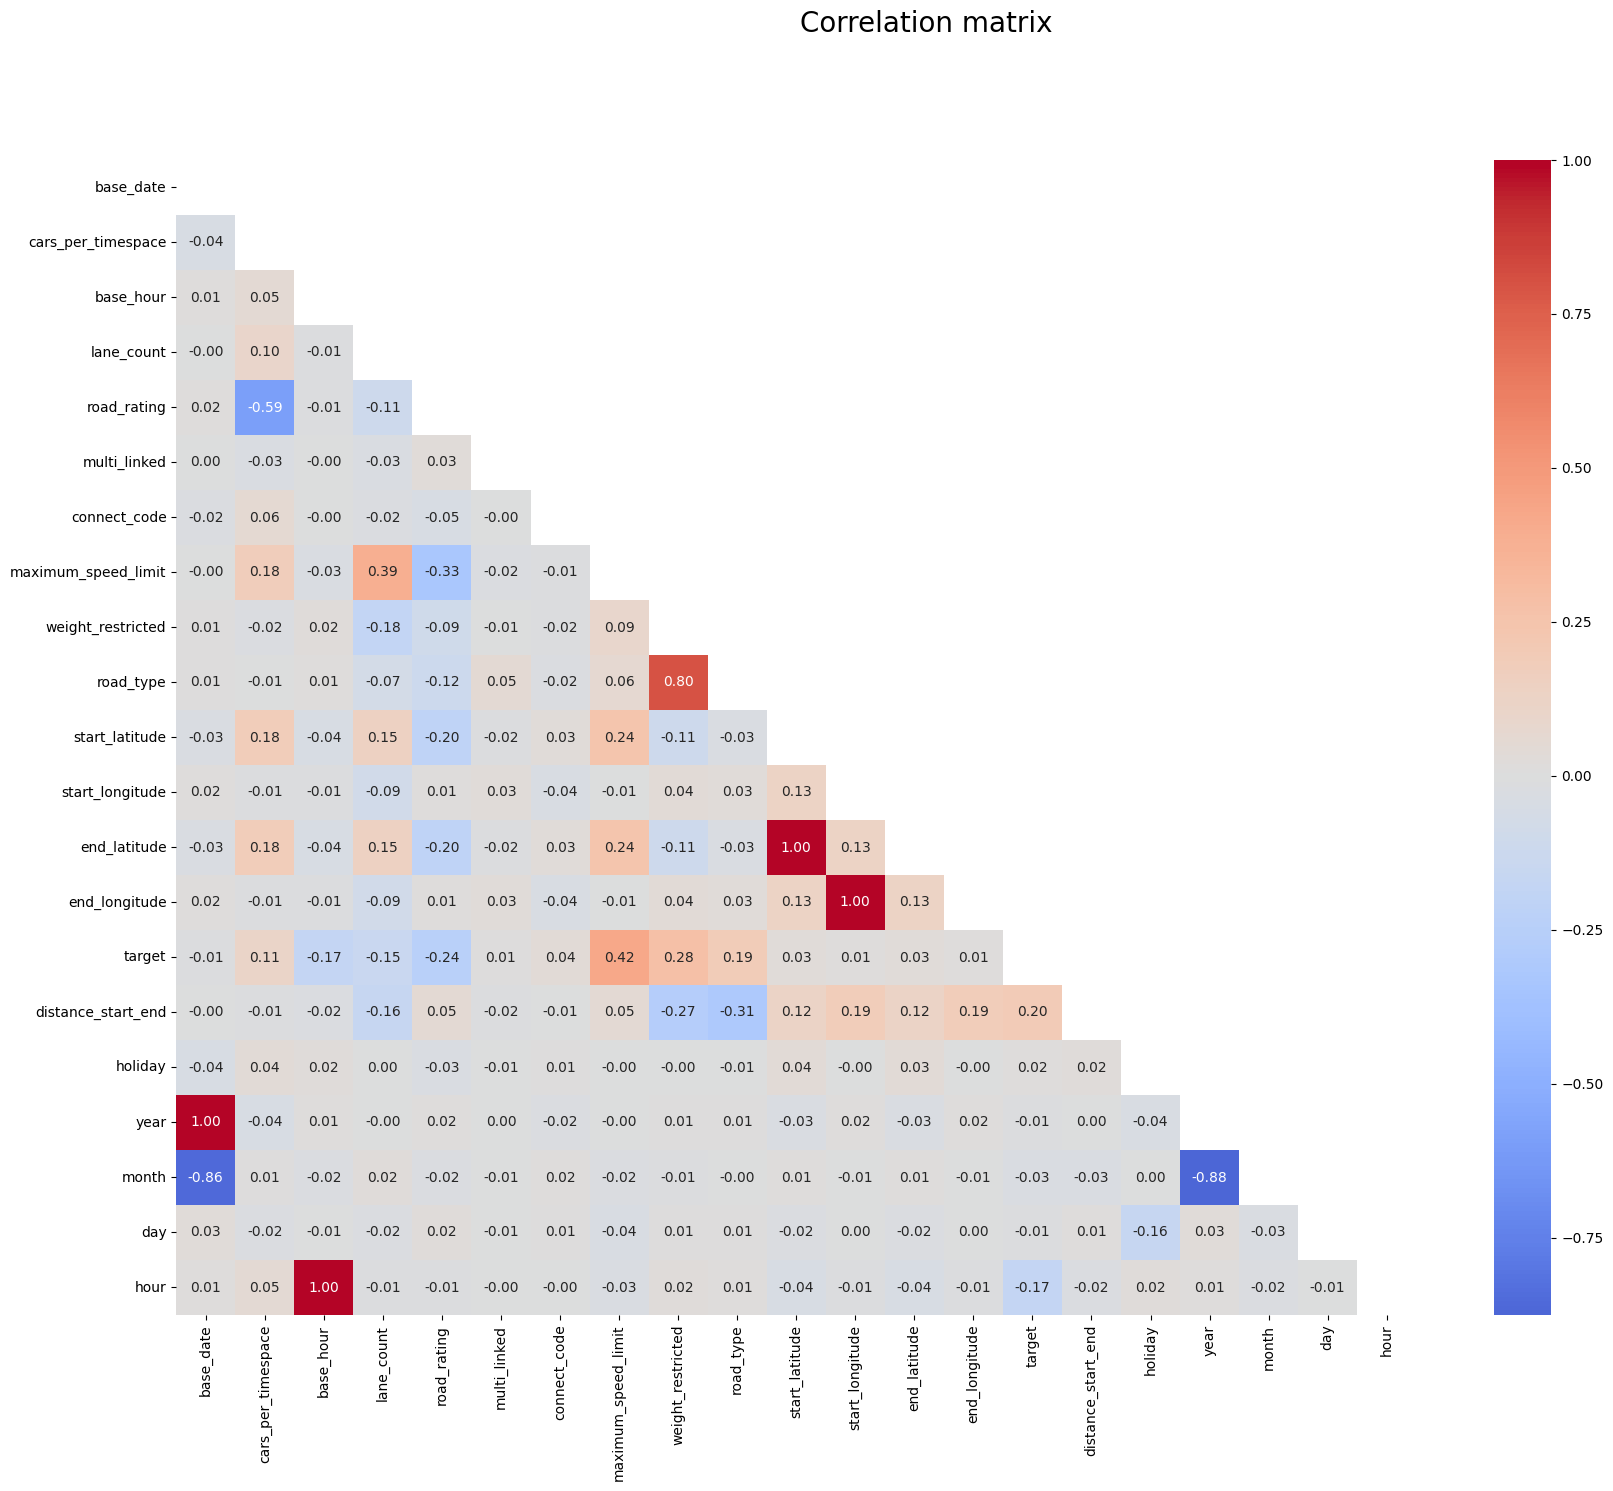

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Title = "Correlation matrix"

figsize = (20, 15)
fontsize = 20
sample = train.sample(5000, random_state=42)

fig, ax = plt.subplots(figsize=figsize)

mask_mat = np.eye(len(sample.corr()), dtype=bool)
mask_mat[np.triu_indices_from(mask_mat, k=1)] = True
sns.heatmap(sample.corr(), mask=mask_mat, ax=ax, annot=True, fmt=".2f", cmap='coolwarm', center=0)

ax.set_xlabel(None), ax.set_ylabel(None);
fig.suptitle(Title, fontsize=fontsize)
plt.show()
plt.close(fig)

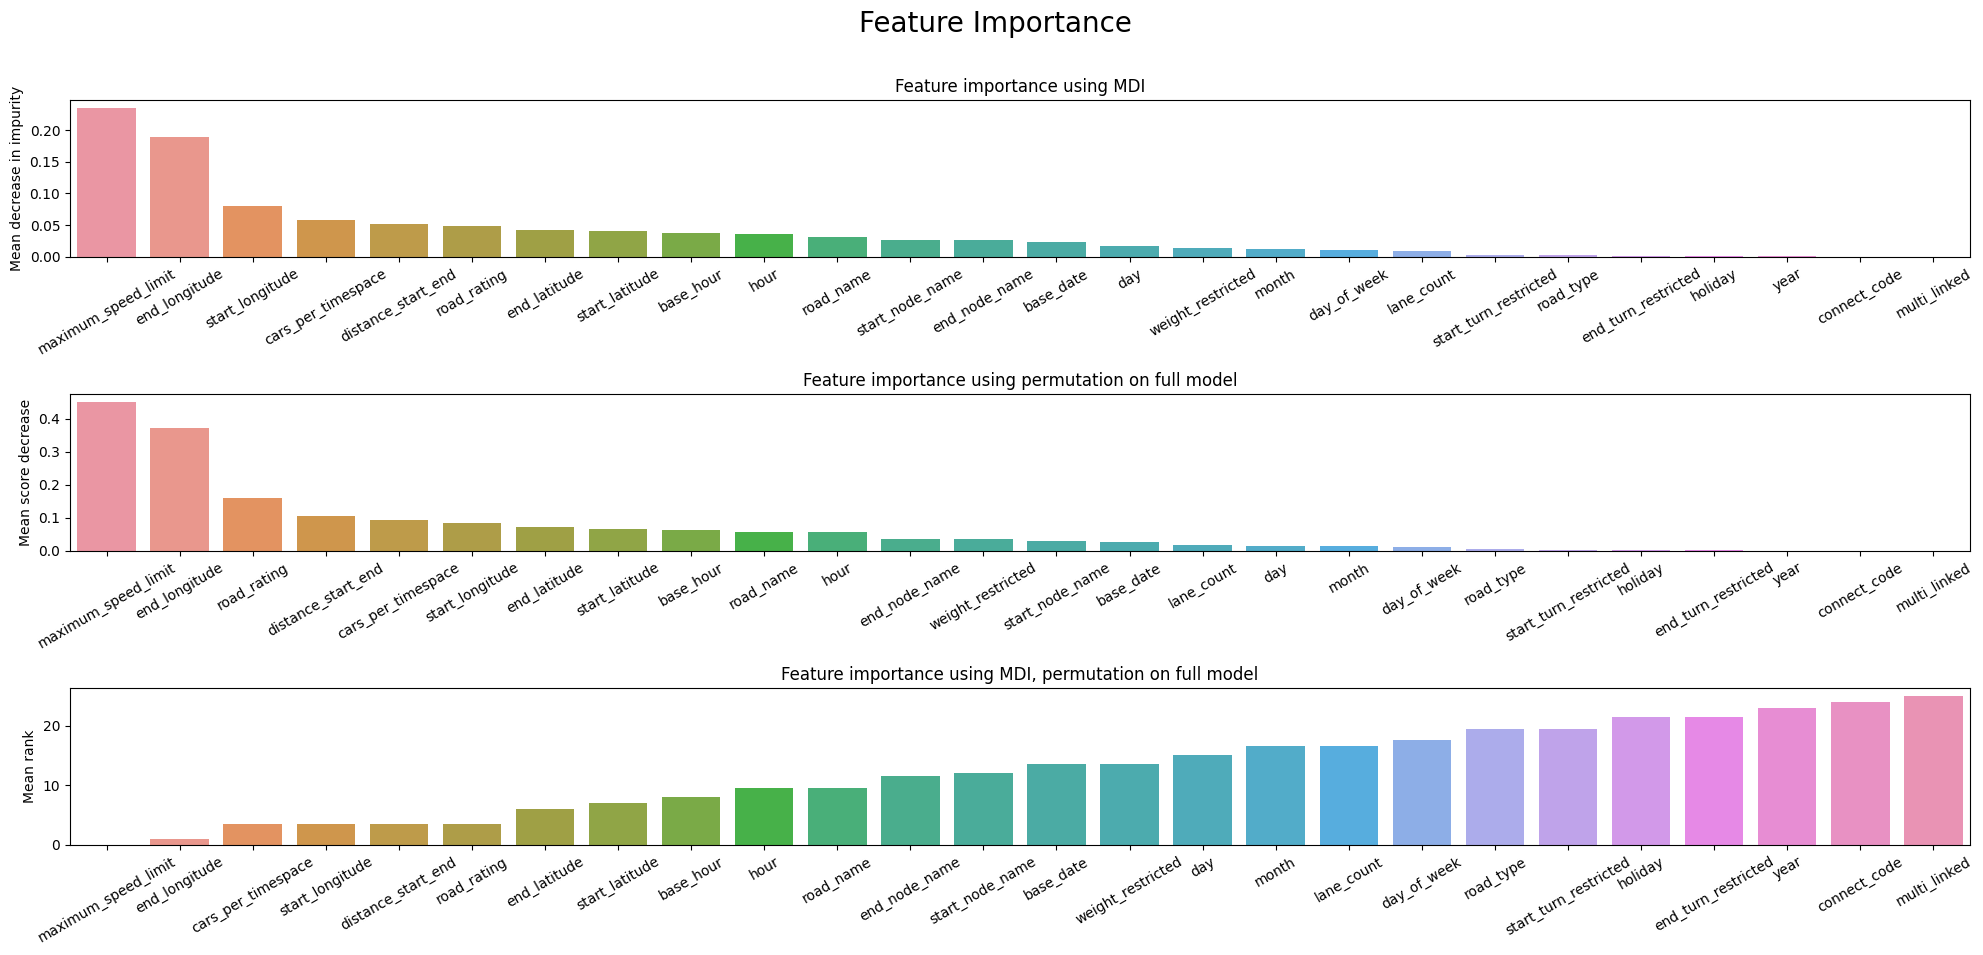

In [23]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder

sample = train.sample(5000, random_state=42)
sample.drop('date', axis=1, inplace=True)
# 1. Feature encoding

    ## nominal categorical features(over two class) --> OneHotEncoder
    ## 여기서는 단순히 LabelEncoder를 통해 인코딩 후 importance 확인
cat_nom_features = ['road_name', 'start_node_name', 'end_node_name']
sample[cat_nom_features] = sample[cat_nom_features].apply(LabelEncoder().fit_transform)

    ## nominal categorical features(two class) --> LabelEncoder
binary_features = ['start_turn_restricted', 'end_turn_restricted']
sample[binary_features] = sample[binary_features].apply(LabelEncoder().fit_transform)

    ## ordinal categorical features --> OrdinalEncoder
cat_ord_features = ['base_hour', 'base_date', 'day_of_week']
categories = [sorted(sample[col].unique()) for col in cat_ord_features]
categories[2] = ['월', '화', '수', '목', '금', '토', '일']
encoder = OrdinalEncoder(categories=categories)
sample[cat_ord_features] = encoder.fit_transform(sample[cat_ord_features])

# 2. Split data into X, y
X, y = sample.drop(columns='target'), sample['target']

# 3. Model (for Regression problem)
model = RandomForestRegressor(n_jobs=-1)
model.fit(X, y)

# 4. Get feature importance
MDI_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
perm_importance = pd.Series(permutation_importance(model, X, y).importances_mean, index=X.columns).sort_values(ascending=False)

# 5. Mean importance
fi1 = pd.Series(range(len(MDI_importance)), index=MDI_importance.index, name='MDI')
fi2 = pd.Series(range(len(perm_importance)), index=perm_importance.index, name='Permutation')
mean_fi = pd.Series(((fi1 + fi2)/2).sort_values(), name='Mean')

# 6. Plot
bins = 50
Title = 'Feature Importance'
fontsize = 20
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

for ax, d, ylabel, title in zip(axes,
                                  [MDI_importance.head(bins), perm_importance.head(bins), mean_fi.head(bins)],
                                  ["Mean decrease in impurity", "Mean score decrease", "Mean rank"],
                                  ["Feature importance using MDI", "Feature importance using permutation on full model", 
                                   "Feature importance using MDI, permutation on full model"]):
    sns.barplot(x=d.index, y=d, ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=30)
    
fig.suptitle(Title, fontsize=fontsize)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
plt.close(fig)

---

---

### 10. Cyclic encoding - 'month', 'day', 'hour', 'day_of_week'

In [24]:
def cyclic_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)

cyclic_encode(train, 'month', 12)
cyclic_encode(test, 'month', 12)

cyclic_encode(train, 'day', 31)
cyclic_encode(test, 'day', 31)

cyclic_encode(train, 'hour', 24)
cyclic_encode(test, 'hour', 24)

In [25]:
from sklearn.preprocessing import OrdinalEncoder

## 'day_of_week' need to be nominal encoded before cyclic encoding
ordinal_encoder = OrdinalEncoder(categories=[['월', '화', '수', '목', '금', '토', '일']])

encoded_tr = ordinal_encoder.fit_transform(train[['day_of_week']])
encoded_te = ordinal_encoder.fit_transform(test[['day_of_week']])

train[['day_of_week']] = encoded_tr
test[['day_of_week']] = encoded_te

cyclic_encode(train, 'day_of_week', 7)  # 0 ~ 6
cyclic_encode(test, 'day_of_week', 7)

In [26]:
corr_matrix = train.corr()
cyclic = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']
corr_matrix['target'].sort_values(ascending=False)[cyclic]

/tmp/ipykernel_18356/351880307.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


month_sin          0.012234
month_cos          0.044729
day_sin            0.011804
day_cos           -0.000265
hour_sin           0.142113
hour_cos           0.182358
day_of_week_sin   -0.004497
day_of_week_cos    0.005977
Name: target, dtype: float64

In [27]:
conven = ['month', 'day', 'hour', 'day_of_week']
corr_matrix['target'].sort_values(ascending=False)[conven]

month         -0.000225
day           -0.011605
hour          -0.159407
day_of_week    0.005911
Name: target, dtype: float64

### 11. Spatial encoding - 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude'

In [28]:
from sklearn.decomposition import PCA

def spatial_encode(data):
    start_coord = data[['start_latitude', 'start_longitude']]
    end_coord = data[['end_latitude', 'end_longitude']]

    pca = PCA(n_components=2)

    start_coord_pca = pca.fit_transform(start_coord)
    end_coord_pca = pca.fit_transform(end_coord)
    
    data['start_coord_pca1'] = start_coord_pca[:, 0]
    data['start_coord_pca2'] = start_coord_pca[:, 1]
    data['end_coord_pca1'] = end_coord_pca[:, 0]
    data['end_coord_pca2'] = end_coord_pca[:, 1]

In [29]:
spatial_encode(train)
spatial_encode(test)

In [30]:
corr_matrix = train.corr()
spatial = ['start_coord_pca1', 'start_coord_pca2', 'end_coord_pca1', 'end_coord_pca2']
corr_matrix['target'].sort_values(ascending=False)[spatial]

/tmp/ipykernel_18356/930658279.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


start_coord_pca1    0.002059
start_coord_pca2   -0.036687
end_coord_pca1      0.002213
end_coord_pca2     -0.036509
Name: target, dtype: float64

In [31]:
conven = ['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']
corr_matrix['target'].sort_values(ascending=False)[conven]

start_latitude     0.036280
start_longitude   -0.001168
end_latitude       0.036139
end_longitude     -0.001000
Name: target, dtype: float64

### 12. Ordinal, Nominal encoding 

- Nominal:
    - start_turn_restricted
    - end_turn_restricted
    - road_type
    - road_rating
    - multi_linked
    - connect_code
<br></br>
- Ordinal:
    - maximum_speed_limit
    - weight_restricted
    - lane_count
    - base_date
    - base_hour
    - day_of_week → cyclic encoding 과정에서 이미 ordinal encoding 수행

In [32]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

def encode(data, encoder, features):
    for i in features:
        encoded = encoder.fit_transform(data[[i]])
        encoded = pd.DataFrame(encoded, columns=[i])
        data[[i]] = encoded

In [33]:
import warnings
warnings.filterwarnings(action='ignore')

nominal_features = ['road_type', 'road_rating', 'multi_linked', 'connect_code', 'start_turn_restricted', 'end_turn_restricted']
ordinal_features = ['maximum_speed_limit', 'weight_restricted', 'lane_count', 'base_date', 'base_hour']

nominal_encoder = LabelEncoder()

categories_tr = [sorted(train[col].unique()) for col in ordinal_features]
ordinal_encoder_tr = OrdinalEncoder(categories=categories_tr)

categories_te = [sorted(test[col].unique()) for col in ordinal_features]
ordinal_encoder_te = OrdinalEncoder(categories=categories_te)

In [34]:
train[nominal_features] = train[nominal_features].apply(nominal_encoder.fit_transform)
train[ordinal_features] = ordinal_encoder_tr.fit_transform(train[ordinal_features])

test[nominal_features] = test[nominal_features].apply(nominal_encoder.fit_transform)
test[ordinal_features] = ordinal_encoder_te.fit_transform(test[ordinal_features])

### 13. OneHot encoding

In [35]:
## 'road_name', 'start_node_name', 'end_node_name'
## 400개가 넘는 높은 cardinality의 feature이므로 단순히 onehot encoding만 해주는 것으로는 좋지 않음
## NeuralNet으로 모델링할 경우 PCA를 통해 dimension을 줄여주는 것이 좋아보임
## traffic 데이터가 categorical feature가 많은 데이터이므로 CatBoost와 같은 Tree 기반 모델을 사용하는 것도 좋아보이는데
## 이러한 경우 따로 encoding을 하지 않아도 모델에서 알아서 처리해줄 것

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import SparsePCA

# large_cardinality = ['road_name', 'start_node_name', 'end_node_name']
large_cardinality = ['road_name']

for i in large_cardinality:
    print(f'train | {i}')
    categories = sorted(train[i].unique())
    onehot = OneHotEncoder(categories=[categories])
    s_pca = SparsePCA(n_components=5)
    encoded = onehot.fit_transform(train[[i]])
    encoded = s_pca.fit_transform(encoded.todense())
    encoded = pd.DataFrame(encoded, columns=[f'{i}_pca{n}' for n in range(1, 6)], index=train.index)
    train = pd.concat([train, encoded], axis=1)
    
for i in large_cardinality:
    print(f'test | {i}')
    encoded = onehot.transform(test[[i]])
    encoded = s_pca.transform(encoded.todense())
    encoded = pd.DataFrame(encoded, columns=[f'{i}_pca{n}' for n in range(1, 6)], index=test.index)
    test = pd.concat([test, encoded], axis=1)
    
encoded =0

train | road_name
test | road_name


In [37]:
## 'start_node_name', 'end_node_name' : memory issue와 크지 않은 importance로 두 column은 제거
## 'date' : 학습에 불필요한 feature
## 'road_name' : 이미 encoding하여 별도의 feature가 만들어짐
## importance가 낮은 feature 일부 제거
## --> 'road_type', 'multi_linked', 'connect_code', 'holiday', 'year', 'start_trun_restricted', 'end_turn_restricted'

In [38]:
drop_list = ['road_type', 'multi_linked', 'connect_code', 'holiday', 'year', 
             'start_turn_restricted', 'end_turn_restricted', 'date', 'road_name', 'start_node_name', 'end_node_name']

train.drop(drop_list, axis=1, inplace=True)
test.drop(drop_list, axis=1, inplace=True)

---

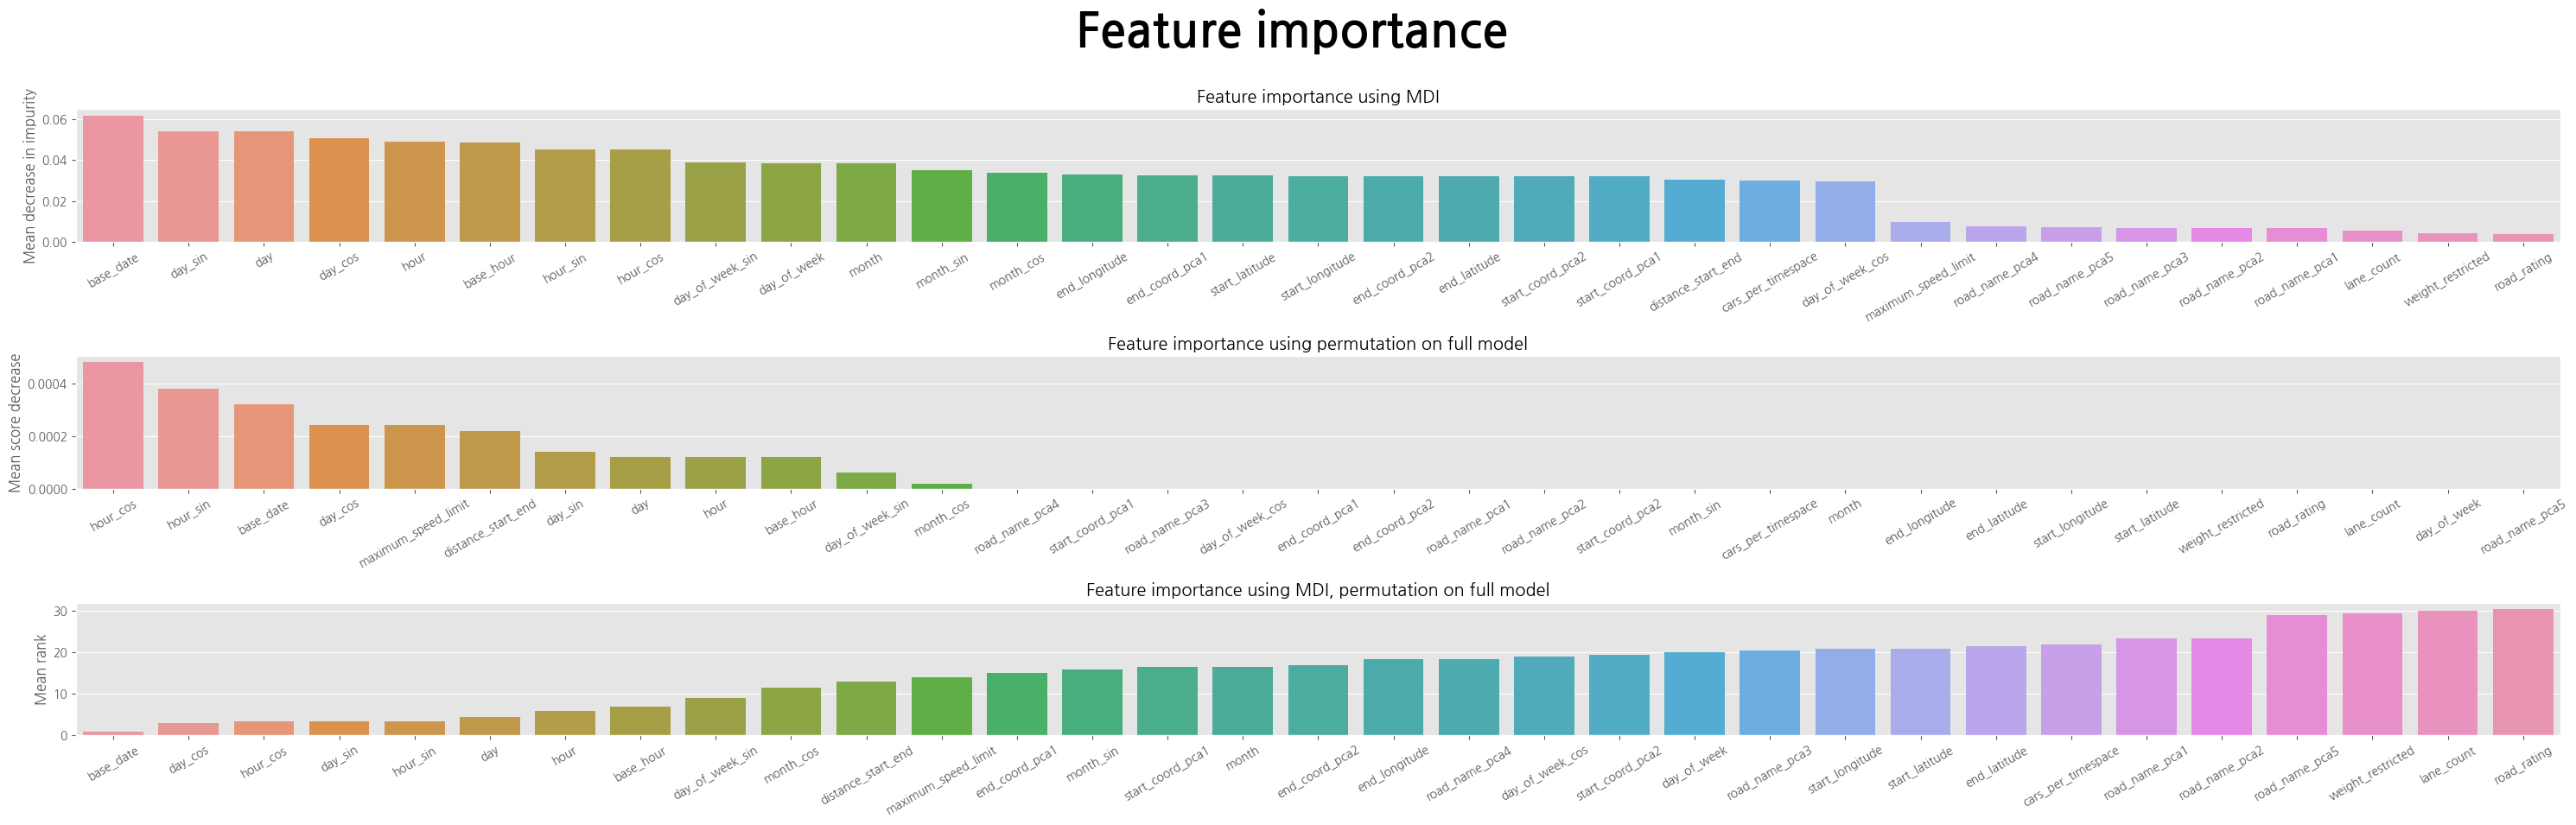

,MDI,Permutation,Mean
base_date,0,2,1.00
day_cos,3,3,3.00
day_sin,1,6,3.50
hour_sin,6,1,3.50
hour_cos,7,0,3.50
day,2,7,4.50
hour,4,8,6.00
base_hour,5,9,7.00
day_of_week_sin,8,10,9.00
month_cos,12,11,11.50


In [41]:
from analysis_tools.common.utils import *
from analysis_tools import utils, random, eda, metrics

sample = train.sample(10000, random_state=42)

metrics.get_feature_importance(sample, 'target')

### 14. Save preproccessed dataset

In [42]:
test = test[train.drop(columns='target').columns.to_list()]

In [43]:
train.to_csv('../../data/prepared_train.csv', index=False)
test.to_csv('../../data/prepared_test.csv', index=False)